<a href="https://colab.research.google.com/github/yusufsugiono/KlasifikasiJudulBerita/blob/main/KlasifikasiJudulBerita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Download Data
!wget https://raw.githubusercontent.com/yusufsugiono/KlasifikasiJudulBerita/main/berita.json

--2022-01-10 14:42:36--  https://raw.githubusercontent.com/yusufsugiono/KlasifikasiJudulBerita/main/berita.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224474 (219K) [text/plain]
Saving to: ‘berita.json’

berita.json         100%[===================>] 219.21K  --.-KB/s    in 0.02s   

2022-01-10 14:42:37 (14.0 MB/s) - ‘berita.json’ saved [224474/224474]



In [3]:
berita = pd.read_json('berita.json')

In [4]:
berita.head()

,judul,kategori
0,Kini Produk Buatan Tangan UMKM Lebih Dicari da...,Bisnis
1,"Dongkrak Produktivitas Petani, Pupuk Indonesi...",Bisnis
2,Meikarta Mulai Topping Off Area Distrik 2,Bisnis
3,Sederet Inovasi Penyaluran BBM Pertamina di Us...,Bisnis
4,"Daftar Terbaru 50 Orang Terkaya di Indonesia, ...",Bisnis


In [5]:
kategori = pd.get_dummies(berita.kategori)

In [6]:
berita = pd.concat([berita, kategori], axis=1)
berita = berita.drop(columns='kategori')

In [7]:
berita

,judul,Bisnis,Health,Tekno
0,Kini Produk Buatan Tangan UMKM Lebih Dicari da...,1,0,0
1,"Dongkrak Produktivitas Petani, Pupuk Indonesi...",1,0,0
2,Meikarta Mulai Topping Off Area Distrik 2,1,0,0
3,Sederet Inovasi Penyaluran BBM Pertamina di Us...,1,0,0
4,"Daftar Terbaru 50 Orang Terkaya di Indonesia, ...",1,0,0
...,...,...,...,...
2137,Lebih Produktif Saat Bekerja di Rumah dengan M...,0,0,1
2138,5 Trik Rahasia WhatsApp Ini Patut Kamu Coba,0,0,1
2139,Ekonom UI: Kolaborasi Gojek dan Bank Jago Baka...,0,0,1
2140,Rahasia Main Game Free Fire Biar Selalu Booyah,0,0,1


# Bagian Baru

In [8]:
judul = berita['judul']
label = berita[['Bisnis', 'Health', 'Tekno']].values

In [9]:
from sklearn.model_selection import train_test_split
judul_latih, judul_test, label_latih, label_test = train_test_split(judul, label, test_size=0.2, random_state=42)

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
pad_type = 'pre'
trunc_type = 'pre'

# Tokenize our training data
tokenizer = Tokenizer(num_words=2000, oov_token='x')
tokenizer.fit_on_texts(judul_latih) 
tokenizer.fit_on_texts(judul_test)

# Encode training data sentences into sequences
sekuens_latih = tokenizer.texts_to_sequences(judul_latih)
sekuens_test = tokenizer.texts_to_sequences(judul_test)

# Get max training sequence length
maxlen = max([len(x) for x in sekuens_latih])

# Pad the training sequences
padded_latih = pad_sequences(sekuens_latih, padding=pad_type, truncating=trunc_type, maxlen=maxlen) 
padded_test = pad_sequences(sekuens_test, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

In [12]:
padded_latih[0]

array([   0,    0,    0,    3,    2,    4,    6, 1322,   81, 1138,   15,
         13,  188,  133,  275,   46, 1322], dtype=int32)

In [13]:
padded_test[0]

array([   0,    0,    0,    0,    0,    0,    0,  479,  205,   14,    3,
          2,   29, 1322,   19,   49,    6], dtype=int32)

In [14]:
import tensorflow as tf
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(input_dim=2000, output_dim=8),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(3, activation='softmax')
  ])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [15]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [16]:
num_epochs = 40
hist = model.fit(padded_latih, label_latih, epochs=num_epochs,
                    validation_data=(padded_test, label_test),
                    verbose=2, callbacks=[callbacks])

Epoch 1/40
54/54 - 3s - loss: 1.0854 - accuracy: 0.3806 - val_loss: 1.0814 - val_accuracy: 0.3846 - 3s/epoch - 63ms/step
Epoch 2/40
54/54 - 1s - loss: 1.0632 - accuracy: 0.4104 - val_loss: 1.0226 - val_accuracy: 0.5058 - 507ms/epoch - 9ms/step
Epoch 3/40
54/54 - 1s - loss: 0.9259 - accuracy: 0.5231 - val_loss: 0.8486 - val_accuracy: 0.6084 - 530ms/epoch - 10ms/step
Epoch 4/40
54/54 - 1s - loss: 0.7657 - accuracy: 0.6760 - val_loss: 0.6924 - val_accuracy: 0.7389 - 523ms/epoch - 10ms/step
Epoch 5/40
54/54 - 0s - loss: 0.6233 - accuracy: 0.7513 - val_loss: 0.6090 - val_accuracy: 0.7436 - 485ms/epoch - 9ms/step
Epoch 6/40
54/54 - 0s - loss: 0.4944 - accuracy: 0.8272 - val_loss: 0.5557 - val_accuracy: 0.7995 - 499ms/epoch - 9ms/step
Epoch 7/40
54/54 - 0s - loss: 0.3788 - accuracy: 0.8698 - val_loss: 0.5084 - val_accuracy: 0.8228 - 500ms/epoch - 9ms/step
Epoch 8/40
54/54 - 1s - loss: 0.3279 - accuracy: 0.8908 - val_loss: 0.4998 - val_accuracy: 0.8252 - 519ms/epoch - 10ms/step
Epoch 9/40
54/5

In [17]:
import matplotlib.pyplot as plt

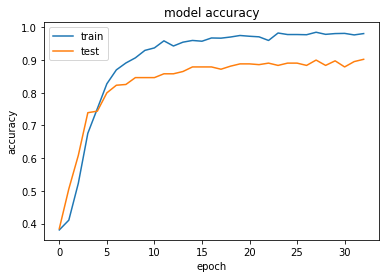

In [18]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

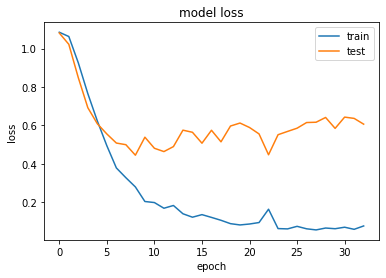

In [19]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [20]:
#function to make predictions
def make_predictions(model, tokenizer, ml):
  classes = ['Bisnis', 'Health', 'Tekno']
  while True:
    text = input('Masukkan judul berita: ')
    text = [text]
    t = tokenizer.texts_to_sequences(text)
    t = pad_sequences(t, padding='pre', truncating='pre', maxlen=ml)
    pred_t = model.predict(t)
    print('Prediksi: ', classes[pred_t.argmax()])
    lagi = input('Apakah ingin mencoba lagi? (y/n) :')
    if lagi=='n' or lagi=='N':
      break

In [21]:
make_predictions(model, tokenizer, maxlen)

Masukkan judul berita: Risiko meningkat, investasi obligasi korporasi masih menarik
Prediksi:  Bisnis
Apakah ingin mencoba lagi? (y/n) :n


# Simpan Model

In [22]:
# Simpan dalam format HDF5
model.save("model.h5")

In [23]:
# Install tensorflowjs
!pip install tensorflowjs

     |████████████████████████████████| 77 kB 3.8 MB/s 


In [25]:
# Convert model.h5 ke tfjs_model
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model